In [1]:
import os
import json
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image

#from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imread, imshow

#from keras.preprocessing.image import ImageDataGenerator
#from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
#import imageio
from nst_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

#%aimport 

SEED=1
random.seed(SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)

K.clear_session()
#K.set_image_data_format('channels_last')
#K.set_learning_phase(1)



Using TensorFlow backend.


In [2]:
print(tf.__version__)

1.14.0


# Load data

For phase1, training examples are images shown to 4 participants across multiple sessions.

Images labeled for 3 classes: scenes, coco, imgnet


In [3]:
stList = {}
stimulusDirPath = os.path.join('images', 'BOLD5000_Stimuli', 'Scene_Stimuli', 'Presented_Stimuli')
print("stimulusDirPath: %s" % stimulusDirPath)
data_split = {
    "train": {
        "participant_list": ["CSI1", "CSI2"],
        "start_sess": 1,
        "last_sess": 4,
        "start_run": 1,
        "last_run": 9
    },
    "dev": {
        "participant_list": ["CSI3"],
        "start_sess": 1,
        "last_sess": 3,
        "start_run": 1,
        "last_run": 5
    }
}
classes = {'ImageNet': 0, 'COCO': 1, 'Scene': 2}


# Get list of stimuli pictures shown in each session in each run
for data_type, items in data_split.items():
    stList[data_type] = {}
    for participant in items['participant_list']:
        
        # CS1 file are missing 1 after CSI
        if participant == "CSI1":
            CSI = "CSI"
        else:
            CSI = participant
        
        stList[data_type][participant] = {}
        for sNum in range(items['start_sess'], items['last_sess']):
            sSes = "sess" + str(sNum).zfill(2)
            stList[data_type][participant][sSes] = {}
            for rNum in range(items['start_run'], items['last_run']):
                sRun = "run" + str(rNum).zfill(2)
                dir_path = os.path.join("images","BOLD5000_Stimuli", "Stimuli_Presentation_Lists",participant, participant + "_" + sSes)
                #print(stimulusDirPath)
                stimulusListFilename = os.path.join(dir_path, "_".join([CSI, sSes, sRun]) + ".txt")
                #print(stimulusListFilename)
                with open(stimulusListFilename) as f:
                    stList[data_type][participant][sSes][sRun] = f.read().splitlines() 

            
x_images_path = {}
y_labels = {}
for data_type, participantDict in stList.items():
    x_images_path[data_type] = {}
    y_labels[data_type] = {}
    for participant, sessDict in participantDict.items(): 
        x_images_path[data_type][participant] = {}
        y_labels[data_type][participant] = {}
        for sess, runDict in sessDict.items():
            x_images_path[data_type][participant][sess] = {}
            y_labels[data_type][participant][sess] = {}
            for run, imageList in runDict.items():
                x_images_path[data_type][participant][sess][run] = []
                y_labels[data_type][participant][sess][run] = []
                #print("sess: %s, run: %s" %(sess, run))
                labelList = []
                for imageFileName in imageList:
                    for (currDir, _, fileList) in os.walk(stimulusDirPath):
                        currBaseDir = os.path.basename(currDir)
                        for filename in fileList:
                            if filename in imageFileName:
                                fullFilename = os.path.join(currDir, filename)
                                x_images_path[data_type][participant][sess][run].append(fullFilename)
                                # using directory path to determine class
                                labelList.append(classes.get(currDir.split('/')[-1]))
                                break
        
                y_labels[data_type][participant][sess][run] = np.reshape(np.asarray(labelList), (1, -1))

# Todo: normalize data
# x_train / 255.0, x_val/255.0, x_train/255.0

#print(x_images_path)
print(y_labels["train"]["CSI1"]['sess01']['run01'].shape)
print(y_labels["dev"]["CSI3"]['sess01']['run01'].shape)
print(len(x_images_path["train"]["CSI1"]['sess01']['run02']))
print('done')

stimulusDirPath: images/BOLD5000_Stimuli/Scene_Stimuli/Presented_Stimuli
(1, 37)
(1, 37)
37
done


# Preprocess 
Compute feature vectors using pretrained imagenet-vgg-verydeep model

Feature vectors saved in file



In [4]:
def unrollContentOutput(cOutput):
    m, n_H, n_W, n_C = cOutput.shape
    output = np.transpose(np.reshape(cOutput, (n_H * n_W, n_C)))
    return output

!mkdir -p stimulifeatures

tf.reset_default_graph()
#sess = tf.InteractiveSession()
#precompute content vectors from presented stimuli
#content_layer = 'conv4_2'
content_layer = 'avgpool5'
stimuli_features_dir = 'stimulifeatures'
with tf.Session() as ts:
    vmodel = load_vgg_model("imagenet-vgg-verydeep-19.mat")
    for data_type, participantDict in x_images_path.items():
        for participant, sessDict in participantDict.items():
            for sess, runDict in sessDict.items():
                for run, imageList in runDict.items():
                    #x_content = {sess: {run: []}}
                    file_path= os.path.join(stimuli_features_dir, "_".join([participant, sess, run]) + ".npy")
                    if os.path.exists(file_path):
                        #print already computed, skip
                        continue

                    print("file_path: %s" % file_path)
                    print("participant: %s, sess: %s, run: %s" % (participant, sess, run))
                    contentList = []
                    for img_path in imageList:
                        #stImage = imread(cImage)
                        img = image.load_img(img_path, target_size=(375, 375))
                        x = image.img_to_array(img)
                        x = np.expand_dims(x, axis=0)
                        x = preprocess_input(x)
                        #print("img_path: %s" % img_path)
                        #print('Input image shape:', x.shape)
                        #img_array = img_to_array(img)
                        #stImage = imageio.imread(img_path)
                        #print("img_path: %s" % img_path)
                        #print(stImage.shape)
                        #stImage = reshape_and_normalize_image(stImage)
                        #stImage = np.reshape(stImage, (1, 375, 375, 3))
                        ts.run(vmodel['input'].assign(x))
                        #a_C = sess.run(vmodel)
                        out = vmodel[content_layer]
                        contentOut = ts.run(out)
                        contentList.append(unrollContentOutput(contentOut))
            
                    #x_content[sess][run] = np.asarray(contentList)
                    contentArray = np.asarray(contentList)
                    # shape is (35, 512, 144): num of pictures, channels, width*height
                    #print(x_content[sess][run].shape)
                    #x_content[sess][run].append(unrollContentOutput(contentOut))
        
                    #np.save(file_path, x_content)
                    np.save(file_path, contentArray)
                    #del x_content

with tf.Session() as ts:
    vmodel = load_vgg_model("imagenet-vgg-verydeep-19.mat")
    img_path = './images/BOLD5000_Stimuli/Scene_Stimuli/Presented_Stimuli/ImageNet/n01833805_1411.JPEG'
    img = image.load_img(img_path, target_size=(375, 375))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    ts.run(vmodel['input'].assign(x))
    out = vmodel[content_layer]
    predictContentOut = ts.run(out)

print('done')

W1030 03:25:36.973730 140389025142528 deprecation_wrapper.py:119] From /home/ubuntu/fmriNet/nst_utils.py:127: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



done


# Model

In [5]:
num_classes = 3
VERSION = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
file_path = os.path.join('stimulifeatures', 'CSI2_sess01_run01.npy')

x_content = np.load(file_path, allow_pickle=True)
print(x_content.shape)

def dnn_classifier(input_shape, num_classes):
    X_input = Input(input_shape)
    X = Flatten()(X_input)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(num_classes, activation='softmax')(X)
    model = Model(inputs = X_input, outputs = X, name='dnn_classifier')
    return model

def cnn_classifier(input_shape, num_classes):
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), padding='same')(X)
    X = Activation('relu')(X)
    X = Conv2D(32, (3, 3))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    X = Conv2D(64, (3, 3), padding='same')(X)
    X = Activation('relu')(X)
    X = Conv2D(64, (3, 3))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.25)(X)
    X = Flatten()(X)
    X = Dense(512)(X)
    X = Activation('relu')(X)
    X = Dense(num_classes)(X)
    X = Activation('softmax')(X)
    model = Model(inputs = X_input, outputs = X, name='cnn_classifier')
    return model

#model = tf.keras.models.Sequential([
#    tf.keras.layers.Flatten(input_shape=[512, 144]),
#    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(num_classes, activation='softmax')
#])

#model = tf.keras.models.Sequential([
#    tf.keras.layers.Conv2D(32, (3, 3), padding='same',
#                 input_shape=x_train.shape[1:]),
#    tf.keras.layers.Activation('relu'),
#    tf.keras.layers.Conv2D(32, (3, 3)),
#    tf.keras.layers.Activation('relu'),
#    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#    tf.keras.layers.Dropout(0.25),
#    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
#    tf.keras.layers.Activation('relu'),
#    tf.keras.layers.Conv2D(64, (3, 3)),
#    tf.keras.layers.Activation('relu'),
#    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#    tf.keras.layers.Dropout(0.25),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(512),
#    tf.keras.layers.Activation('relu'),
#    tf.keras.layers.Dense(num_classes),
#    tf.keras.layers.Activation('softmax')
#])


#input_shape=[512, 144]
input_shape = x_content.shape[1:]
model = dnn_classifier(input_shape, num_classes)



W1030 03:25:48.147598 140389025142528 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(37, 512, 144)


In [6]:

initial_epoch = 0


Total number of training examples: 1776
Total number of dev examples: 296
steps_per_epoch: 48
Epoch 1/15
47/48 [============================>.] - ETA: 0s - loss: 2.3132 - acc: 0.5394
Epoch 00001: saving model to weights.01.h5
48/48 [==============================] - 4s 73ms/step - loss: 2.2825 - acc: 0.5400 - val_loss: 0.5051 - val_acc: 0.7331
Epoch 2/15
47/48 [============================>.] - ETA: 0s - loss: 0.5411 - acc: 0.7510
Epoch 00002: saving model to weights.02.h5
48/48 [==============================] - 2s 52ms/step - loss: 0.5436 - acc: 0.7506 - val_loss: 0.3130 - val_acc: 0.8784
Epoch 3/15
47/48 [============================>.] - ETA: 0s - loss: 0.3608 - acc: 0.8315
Epoch 00003: saving model to weights.03.h5
48/48 [==============================] - 2s 50ms/step - loss: 0.3582 - acc: 0.8333 - val_loss: 0.2137 - val_acc: 0.9155
Epoch 4/15
47/48 [============================>.] - ETA: 0s - loss: 0.2731 - acc: 0.8781
Epoch 00004: saving model to weights.04.h5
48/48 [===========

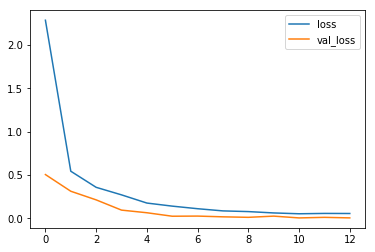

In [7]:

def loadFeatureVector(file_path):
    return np.load(file_path, allow_pickle=True)
    
def featureVectorLoader(x_images_path, data_type):
    #every file has 35 feature vectors (one batch)
    L = len(fileList)   
    x_images = x_images_path.get(data_type, None)
    while True:
        for participant, sessDict in x_images.items():
            for sess, runDict in sessDict.items():
                for run in runDict.keys():
                    file_path= os.path.join(stimuli_features_dir, "_".join([participant, sess, run]) + ".npy")
                    X = loadFeatureVector(file_path)
                    Y = utils.to_categorical(np.transpose(y_labels[data_type][participant][sess][run]))
                    yield (X,Y)

EPOCHS=15
#callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='weights.{epoch:02d}.h5', monitor='val_loss', verbose=1)]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train_history = model.fit(x=x_train, y=y_train, epochs=EPOCHS, callbacks=callbacks, batch_size=35, validation_data=(x_test, y_test))
#train_history = model.fit(x=x_train, y=y_train, epochs=EPOCHS, callbacks=callbacks, batch_size=35, validation_data=(x_test, y_test))
#train_history = model.fit_generator(featureVectorLoader(x_images_path), steps_per_epoch=5, epochs=EPOCHS, callbacks=callbacks) 
#train_history = model.fit_generator(featureVectorLoader(x_images_path), steps_per_epoch=5, epochs=EPOCHS, callbacks=callbacks, validation_data=(x_test, y_test)) 

#steps_per_epoch = (last_sess - 1) * (last_run - 1)

numberOfSessions = data_split["train"]["last_sess"] - data_split["train"]["start_sess"]
numberOfRuns = data_split["train"]["last_run"] - data_split["train"]["start_run"]
numberOfParticipants = len(data_split["train"]["participant_list"])
steps_per_epoch = numberOfSessions * numberOfRuns * numberOfParticipants

numberOfSessions = data_split["dev"]["last_sess"] - data_split["dev"]["start_sess"]
numberOfRuns = data_split["dev"]["last_run"] - data_split["dev"]["start_run"]
numberOfParticipants = len(data_split["dev"]["participant_list"])
validation_steps = numberOfSessions * numberOfRuns * numberOfParticipants


print("Total number of training examples: %s" % (steps_per_epoch * 37))
print("Total number of dev examples: %s" % (validation_steps * 37))

print("steps_per_epoch: %s" % steps_per_epoch)
#train_history = model.fit_generator(featureVectorLoader(x_images_path), steps_per_epoch=350, epochs=EPOCHS, validation_data=(x_test, y_test)) 
#train_history = model.fit_generator(featureVectorLoader(x_images_path, "train"), steps_per_epoch=350, epochs=EPOCHS, validation_data=featureVectorLoader(x_images_path, "train"), validation_steps=350) 
train_history = model.fit_generator(featureVectorLoader(x_images_path, "train"), steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                                    callbacks=callbacks, validation_data=featureVectorLoader(x_images_path, "train"),
                                    validation_steps=validation_steps) 


loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()



# Predict

In [8]:

x = unrollContentOutput(predictContentOut)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)
print(model.predict(x))

Input image shape: (1, 512, 144)
[[9.9750739e-01 2.4926958e-03 2.4027281e-08]]
